In [1]:
from air_hockey_challenge.framework.air_hockey_challenge_wrapper import AirHockeyChallengeWrapper
from air_hockey_challenge.framework.challenge_core import ChallengeCore
from air_hockey_challenge.framework.agent_base import AgentBase
from examples.control.hitting_agent import build_agent

from mushroom_rl.utils.dataset import parse_dataset, select_random_samples
from mushroom_rl.policy import GaussianTorchPolicy

import torch
import torch.nn as nn

from tqdm import tqdm

import pickle

import numpy as np

use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
print(f"Cuda: {use_cuda}")

Cuda: False


In [2]:
class Network(nn.Module):
    def __init__(self, input_shape, output_shape, n_features, **kwargs):
        super(Network, self).__init__()

        self._h1 = nn.Linear(input_shape[0], n_features)
        self._h2 = nn.Linear(n_features, n_features)
        self._h3 = nn.Linear(n_features, output_shape[0])

        nn.init.xavier_uniform_(self._h1.weight,
                                gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self._h2.weight,
                                gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self._h3.weight,
                                gain=nn.init.calculate_gain('linear'))

    def forward(self, obs, **kwargs):
        features1 = torch.tanh(self._h1(torch.squeeze(obs, 1).float()))
        features2 = torch.tanh(self._h2(features1))
        return self._h3(features2)

# policy can only output 1D actions (6,)
policy = GaussianTorchPolicy(Network, (12,), (6,), std_0=1., n_features=64, use_cuda=use_cuda)

In [3]:
from air_hockey_challenge.framework.evaluate_agent import generate_init_states


def generate_init_joint_states(mdp ,env: str = "3dof-hit"):

    # create initial state
    obs = generate_init_states(env=env, n_episodes=1, n_parallel_cores=1)
    obs = obs[0].flatten()

    # get joint position limits
    min_pos_limits = mdp.env_info['robot']['joint_pos_limit'][0, :]
    max_pos_limits = mdp.env_info['robot']['joint_pos_limit'][1, :]

    # generate random joint positions
    random_joint_pos = np.random.uniform(low=min_pos_limits, high=max_pos_limits, size=(3,))

    # save random joint positions in the initial state
    obs[mdp.env_info['joint_pos_ids']] = random_joint_pos

    obs = obs.reshape((1,-1))

    return obs

In [3]:
env = "3dof-hit"

mdp = AirHockeyChallengeWrapper(env)
mdp.reset()

agent = build_agent(mdp.env_info)
core = ChallengeCore(agent, mdp)

n_expert_traj = 500
dataset_path = f'dataset/hit_{n_expert_traj}.pkl'

In [ ]:
dataset = []
success_traj = 0
for i in tqdm(range(n_expert_traj)):
    # initial_state = generate_init_joint_states(mdp, env=env)
    # new_traj = core.evaluate(initial_states=initial_state)
    new_traj = core.evaluate(n_episodes=1)
    _, _, _, _, absorbed, _ = parse_dataset(new_traj)
    if absorbed[-1]: # we do not want examples where the "expert" did not score
        dataset += new_traj
        success_traj += 1
print(f"Dataset size: {len(dataset)} from {success_traj} trajectories")

with open(dataset_path, 'wb') as f:
    pickle.dump(dataset, f)

In [8]:
from air_hockey_challenge.utils.replay_dataset import replay_dataset
replay_dataset(env, dataset_path)

KeyboardInterrupt: 

In [5]:
def train_bc(policy, dataset, n_epochs, batch_size, n_batches_per_epoch, lr=0.0005):
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    
    pbar = tqdm(range(n_epochs), desc='Epoch')
    logs = dict(loss=[], epoch=[])
    for iter in pbar:
        avg = []
        for i in range(n_batches_per_epoch):
            states, actions, rewards, next_states, absorbing, last  = select_random_samples(dataset, batch_size, parse=True)
            states_t = torch.from_numpy(states).to(device)
            expert_actions_t = torch.from_numpy(actions.reshape((batch_size,-1))).to(device)
            
            optimizer.zero_grad()
            loss = -policy.log_prob_t(states_t, expert_actions_t).mean()
            loss.backward()
            optimizer.step()
            avg.append(loss.item())
        
        avg_loss = np.mean(avg)
        pbar.set_postfix({'loss': avg_loss})
        logs['loss'].append(avg_loss)
        logs['epoch'].append(iter)
    return logs

In [9]:

dataset = np.load(f"dataset/hit_{n_expert_traj}.pkl", allow_pickle=True)

logs = train_bc(policy, dataset, 100, 100, 100)
policy.save('dataset/hit_500_policy')

Epoch: 100%|██████████| 100/100 [03:33<00:00,  2.14s/it, loss=-21.6]


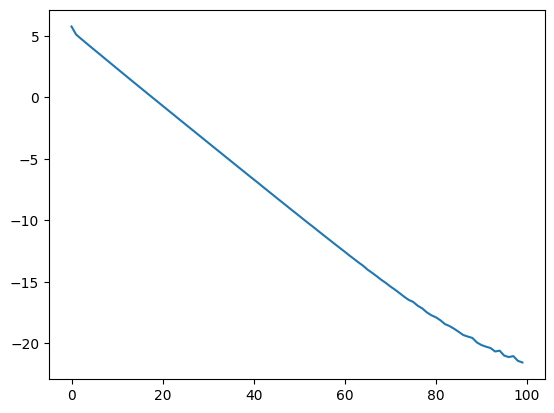

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(logs['epoch'], logs['loss'])

In [4]:
class BCAgent(AgentBase):
    def __init__(self, env_info, policy, **kwargs):
        super().__init__(env_info, **kwargs)
        self.policy = policy

    def reset(self):
        pass

    def draw_action(self, observation):
        return self.policy.draw_action(observation).reshape(2,3)
    

policy = policy.load('dataset/hit_500_policy')

env = "3dof-hit"

mdp = AirHockeyChallengeWrapper(env)
mdp.reset()

agent = BCAgent(mdp.env_info, policy)
core = ChallengeCore(agent, mdp)

# eval = core.evaluate(n_episodes=5, render=False)

In [5]:
def build_agent(env_info, **kwargs):
    """
    Function where an Agent that controls the environments should be returned.
    The Agent should inherit from the mushroom_rl Agent base env.

    :param env_info: The environment information
    :return: Either Agent ot Policy
    """
    if "hit" in env_info["env_name"]:
        return BCAgent(mdp.env_info, policy)

In [8]:
from air_hockey_challenge.framework.evaluate_agent import evaluate

eval = evaluate(build_agent, 'logs/bc_agent', env_list=[env], n_episodes=50, render=False, quiet=False, n_cores=1)

Environment:        3dof-hit
Number of Episodes: 50
Success:            0.0000
Penalty:            212.5
Number of Violations: 
  joint_pos_constr  3
  joint_vel_constr  50
  ee_constr         35
  Jerk              50
  Computation Time  3
  Total             141
-------------------------------------------------



# DAgger

In [ ]:
# make a dataset using pytorch



In [6]:
policy = policy.load('dataset/hit_500_policy')

env = "3dof-hit"

mdp = AirHockeyChallengeWrapper(env)
mdp.reset()

agent = BCAgent(mdp.env_info, policy)
core = ChallengeCore(agent, mdp)

eval = core.evaluate(n_episodes=5, render=False, get_env_info=False)

state, action, reward, next_state, absorbing, last = parse_dataset(eval)

In [8]:
# slice action to show me the first action
# action[0, :, :]


2054

In [20]:
state.shape

(2054, 12)

In [22]:
action[0]

array([[-4.88174170e-01,  5.22910476e-01,  5.11914551e-01],
       [-6.02429174e-03,  1.03983637e-02,  2.70924997e-04]])

In [23]:
reward.shape

(2054,)

In [24]:
next_state.shape

(2054, 12)

In [25]:
absorbing.shape

(2054,)